In [2]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.models import Model, load_model
import sklearn
import array
import pickle
import tarfile
from urllib.request import urlretrieve
import os
import sys
from os import listdir
import nltk
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances
from os.path import isfile, join
from scipy.sparse import csr_matrix, lil_matrix
import numpy as np
from scipy.sparse import save_npz, load_npz
from tensorflow.python.keras import backend as K
import random
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils import plot_model
import pandas as pd
%matplotlib inline

In [3]:
def getTextFromCooc(pathToFile):
    with open(pathToFile, 'r', encoding='utf8') as f:
        indexRow = 0
        headerText = []
        docs = []
        for row in f:
            if(indexRow == 0):
                for word in row.split(','):
                    headerText.append(word)
            else:
                indexNumber = 0
                isStringCreated = False
                for word2 in row.split(','):
                    if(indexNumber == 0):
                        pass
                    else:
                        if int(word2) == 1:
                            if(isStringCreated == False):
                                string = ''
                                isStringCreated = True
                            if(string == ""):
                                string = headerText[indexNumber-1]
                            else:
                                string = string +' '+headerText[indexNumber-1]
                    indexNumber += 1
                #string = string[2:]
                docs.append(string)
                docs = [s.replace("'", '"') for s in docs] # remove all the 8s 
            indexRow +=1
    with open('./docs/textTheGoodScents.txt','wb') as f:
        pickle.dump(docs, f)
    return [docs,headerText]

In [4]:
docs,headerText = getTextFromCooc('./Oniris/data.csv')
docs = [s.replace(" ", '') for s in docs]
docs = [s.replace('""', '" "') for s in docs]
headerText = headerText[1:]
print(len(headerText))
print(headerText)

54
['"à noyaux"', '"agrumes"', '"alcool"', '"aldehyde"', '"amande amère"', '"amylique"', '"animal"', '"anise"', '"autre"', '"beurre"', '"boise"', '"caramel"', '"champignon"', '"chimique"', '"cuir"', '"doux"', '"empyreumatique"', '"epice"', '"fermentaire"', '"floral"', '"fruite"', '"fruits à pépins"', '"fruits cuits"', '"fruits exotiques"', '"fruits jaunes"', '"fruits noirs"', '"fruits rouges"', '"fruits secs"', '"fumé"', '"géranium"', '"inconnu"', '"lactique"', '"lactone"', '"légumes cuits"', '"levure"', '"malte"', '"menthe"', '"métallique"', '"mineral"', '"moisi-terreux"', '"noyau de cerise"', '"pharmaceutique"', '"pieds"', '"pomme de terre"', '"pyrazique"', '"rose"', '"soufre"', '"thiol vegetal"', '"vanille"', '"vegetal sec"', '"vegetal vert"', '"vinaigre"', '"violette"', '"vomi"\n']


In [5]:
v_size = len(headerText)
tokenizer = Tokenizer(num_words=v_size)
tokenizer.fit_on_texts(docs)

In [6]:
generate_cooc = False
def generate_cooc_matrix(text, tokenizer, window_size, n_vocab, use_weighting=True):
    sequences = tokenizer.texts_to_sequences(text)
    meanLen = 0
    meanNumber = 0
    for sequence in sequences:
        meanLen += len(sequence)
        meanNumber +=1
    meanLen = meanLen/meanNumber
    window_size = round(meanLen)
    cooc_mat = lil_matrix((n_vocab, n_vocab), dtype=np.float32)
    for sequence in sequences:
        window_size = int(len(sequence)/2)
        if(len(sequence) % 2 == 0):
            for i, wi in zip(np.arange(window_size, len(sequence)-window_size+1), sequence[window_size-1:-window_size]):
                context_window = sequence[i-window_size: i+window_size+1]
                distances = np.abs(np.arange(-(window_size-1), window_size+1))
                distances[window_size] = 1.0
                nom = np.ones(shape=(window_size*2,), dtype=np.float32)
                nom[window_size-1] = 0.0
                if use_weighting:
                    cooc_mat[wi, context_window] += nom/distances    # Update element
                else:
                    for y in range(0,len(sequence)-1):
                        nom = np.ones(shape=(window_size*2,), dtype=np.float32)
                        nom[y] = 0.0
                        cooc_mat[sequence[y], context_window] += nom
        else:
            for i, wi in zip(np.arange(window_size, len(sequence)-window_size), sequence[window_size:-window_size]):
                context_window = sequence[i-window_size: i+window_size+1]
                distances = np.abs(np.arange(-window_size, window_size+1))
                distances[window_size] = 1.0
                nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
                nom[window_size] = 0.0
                if use_weighting:
                    cooc_mat[wi, context_window] += nom/distances    # Update element
                else:
                    for y in range(0,len(sequence)-1):
                        nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
                        nom[y] = 0.0
                        cooc_mat[sequence[y], context_window] += nom
    return cooc_mat    

if not generate_cooc:
    cooc_mat = generate_cooc_matrix(docs, tokenizer, 4, v_size, False)
    print("Generated......")
    cooc_mat
    save_npz(os.path.join('datasets','cooc_mat.npz'), cooc_mat.tocsr())
else:
    cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz')).tolil()
    print('Cooc matrix of type {} was loaded from disk'.format(type(cooc_mat).__name__))
    
print(cooc_mat)

Generated......
  (1, 2)	8.0
  (1, 3)	8.0
  (1, 4)	5.0
  (1, 5)	5.0
  (1, 6)	5.0
  (1, 7)	6.0
  (1, 8)	4.0
  (1, 9)	2.0
  (1, 10)	3.0
  (1, 11)	4.0
  (1, 12)	5.0
  (1, 13)	6.0
  (1, 14)	3.0
  (1, 15)	2.0
  (1, 16)	5.0
  (1, 17)	4.0
  (1, 18)	2.0
  (1, 19)	2.0
  (1, 20)	1.0
  (1, 21)	2.0
  (1, 22)	4.0
  (1, 23)	4.0
  (1, 24)	4.0
  (1, 25)	2.0
  (1, 26)	2.0
  (1, 27)	3.0
  (1, 28)	4.0
  (1, 29)	4.0
  (1, 30)	3.0
  (1, 33)	1.0
  (1, 34)	3.0
  (1, 35)	4.0
  (1, 36)	3.0
  (1, 39)	2.0
  (1, 40)	1.0
  (1, 42)	1.0
  (1, 43)	1.0
  (1, 44)	1.0
  (1, 45)	4.0
  (1, 46)	3.0
  (1, 47)	1.0
  (1, 48)	1.0
  (1, 49)	1.0
  (1, 50)	1.0
  (1, 51)	2.0
  (1, 53)	1.0
  (2, 1)	8.0
  (2, 3)	21.0
  (2, 4)	6.0
  (2, 5)	3.0
  (2, 6)	5.0
  (2, 7)	3.0
  (2, 8)	6.0
  (2, 9)	8.0
  (2, 10)	7.0
  (2, 11)	3.0
  (2, 12)	5.0
  (2, 13)	2.0
  (2, 14)	4.0
  (2, 15)	3.0
  (2, 16)	3.0
  (2, 17)	4.0
  (2, 18)	4.0
  (2, 19)	3.0
  (2, 20)	3.0
  (2, 21)	3.0
  (2, 22)	3.0
  (2, 23)	1.0
  (2, 24)	5.0
  (2, 25)	2.0
  (2, 26)	5.0
  (2,

# TSNE SUR DONNEES BRUTES

[1.0, 1.0, 1.0, 1.0]
[0.1633988, 0.21669668, 0.2206049, 0.22086221]
[0.19946933, 0.23796195, 0.24057984, 0.24302131]
[0.2129786, 0.21655655, 0.2458815, 0.251684]
[0.19283038, 0.19398457, 0.20835918, 0.21797585]
[0.23311317, 0.263272, 0.2920506, 0.31294006]
[0.17086619, 0.188945, 0.19375712, 0.19398457]
[0.206132, 0.21243751, 0.21293145, 0.2212084]
[0.17253971, 0.19871557, 0.2206049, 0.2210592]
[0.1633988, 0.17253971, 0.17360842, 0.18343079]
[0.17086619, 0.17360842, 0.18788576, 0.21590728]
[0.19456238, 0.206132, 0.22353685, 0.24176985]
[0.20343632, 0.210047, 0.2219193, 0.22353685]
[0.2162363, 0.21797585, 0.21881968, 0.25249135]
[0.26590484, 0.28335023, 0.2886243, 0.29488987]
[0.19283038, 0.19375712, 0.19456238, 0.199534]
[0.2212084, 0.22220558, 0.22511631, 0.23218727]
[0.21225804, 0.22855008, 0.24731857, 0.25070834]
[0.19954318, 0.23072928, 0.2322833, 0.23528087]
[0.18343079, 0.21225804, 0.22564453, 0.23528087]
[0.21727878, 0.2369417, 0.24565327, 0.25666904]
[0.19532162, 0.20719671, 0.2

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.147708
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 117.4741821, gradient norm = 2.3171346 (50 iterations in 0.010s)
[t-SNE] Iteration 100: error = 115.8020248, gradient norm = 2.6590009 (50 iterations in 0.012s)
[t-SNE] Iteration 150: error = 112.0272293, gradient norm = 2.2769318 (50 iterations in 0.011s)
[t-SNE] Iteration 200: error = 110.7304459, gradient norm = 2.5493939 (50 iterations in 0.012s)
[t-SNE] Iteration 250: error = 116.4853592, gradient norm = 2.3245292 (50 iterations in 0.011s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 116.485359
[t-SNE] Iteration 300: error = 0.7153366, gradient norm = 0.0182952 (50 iterations in 0.010s)
[t-SNE] Iteration 350: error = 0.5939587, gradient norm = 0.0036794

[t-SNE] Iteration 850: error = 0.5977788, gradient norm = 0.0001959 (50 iterations in 0.010s)
[t-SNE] Iteration 900: error = 0.5972419, gradient norm = 0.0001589 (50 iterations in 0.011s)
[t-SNE] Iteration 950: error = 0.5970244, gradient norm = 0.0001308 (50 iterations in 0.010s)
[t-SNE] Iteration 1000: error = 0.5970448, gradient norm = 0.0002935 (50 iterations in 0.013s)
[t-SNE] Iteration 1050: error = 0.5972189, gradient norm = 0.0002717 (50 iterations in 0.009s)
[t-SNE] Iteration 1100: error = 0.5972860, gradient norm = 0.0003494 (50 iterations in 0.010s)
[t-SNE] Iteration 1150: error = 0.5972322, gradient norm = 0.0002716 (50 iterations in 0.010s)
[t-SNE] Iteration 1200: error = 0.5972414, gradient norm = 0.0002002 (50 iterations in 0.011s)
[t-SNE] Iteration 1250: error = 0.5971257, gradient norm = 0.0001888 (50 iterations in 0.009s)
[t-SNE] Iteration 1300: error = 0.5972304, gradient norm = 0.0001582 (50 iterations in 0.009s)
[t-SNE] Iteration 1300: did not make any progress dur

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.119473
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 51.7150688, gradient norm = 0.7279685 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 51.0168266, gradient norm = 0.9348388 (50 iterations in 0.010s)
[t-SNE] Iteration 150: error = 47.9713478, gradient norm = 0.6232165 (50 iterations in 0.012s)
[t-SNE] Iteration 200: error = 43.5602226, gradient norm = 1.8035377 (50 iterations in 0.012s)
[t-SNE] Iteration 250: error = 43.5735512, gradient norm = 1.6694846 (50 iterations in 0.011s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.573551
[t-SNE] Iteration 300: error = 0.7969810, gradient norm = 0.0039045 (50 iterations in 0.010s)
[t-SNE] Iteration 350: error = 0.7686539, gradient norm = 0.0009690 (50 i

[t-SNE] Computing 53 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.183230
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 30.5016212, gradient norm = 1.2828642 (50 iterations in 0.012s)
[t-SNE] Iteration 100: error = 34.9604530, gradient norm = 0.9179101 (50 iterations in 0.012s)
[t-SNE] Iteration 150: error = 32.4731750, gradient norm = 1.0481467 (50 iterations in 0.011s)
[t-SNE] Iteration 200: error = 34.3465271, gradient norm = 0.8927799 (50 iterations in 0.013s)
[t-SNE] Iteration 250: error = 34.6766663, gradient norm = 1.0592399 (50 iterations in 0.012s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 34.676666
[t-SNE] Iteration 300: error = 0.3051535, gradient norm = 0.0055550 (50 iterations in 0.010s)
[t-SNE] Iteration 350: error = 0.2761528, gradient norm = 0.0019895 (50 i

[t-SNE] Iteration 50: error = 81.9640732, gradient norm = 2.0947850 (50 iterations in 0.011s)
[t-SNE] Iteration 100: error = 86.5053864, gradient norm = 2.1766479 (50 iterations in 0.013s)
[t-SNE] Iteration 150: error = 86.5693283, gradient norm = 2.2355406 (50 iterations in 0.014s)
[t-SNE] Iteration 200: error = 78.3209457, gradient norm = 2.0881436 (50 iterations in 0.012s)
[t-SNE] Iteration 250: error = 83.1099167, gradient norm = 2.2352695 (50 iterations in 0.013s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.109917
[t-SNE] Iteration 300: error = 0.3489541, gradient norm = 0.0063167 (50 iterations in 0.010s)
[t-SNE] Iteration 350: error = 0.3310816, gradient norm = 0.0029040 (50 iterations in 0.010s)
[t-SNE] Iteration 400: error = 0.3302327, gradient norm = 0.0007637 (50 iterations in 0.010s)
[t-SNE] Iteration 450: error = 0.3302454, gradient norm = 0.0002103 (50 iterations in 0.010s)
[t-SNE] Iteration 500: error = 0.3300857, gradient norm = 0.0004432 (50 

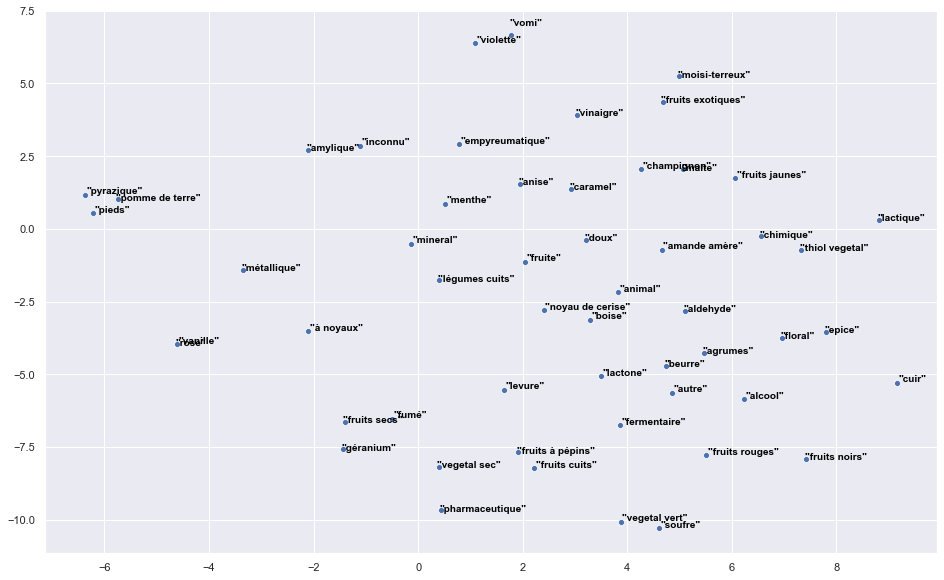

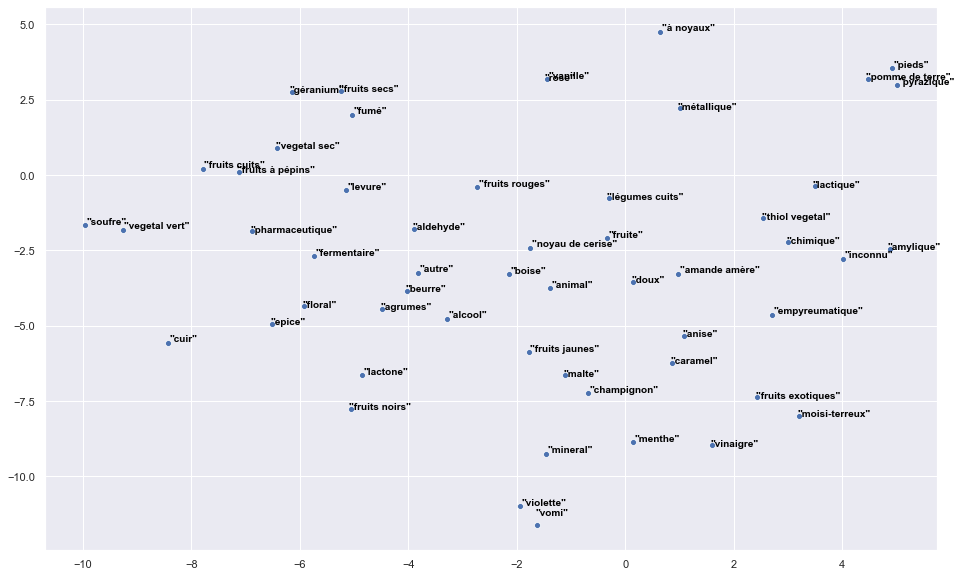

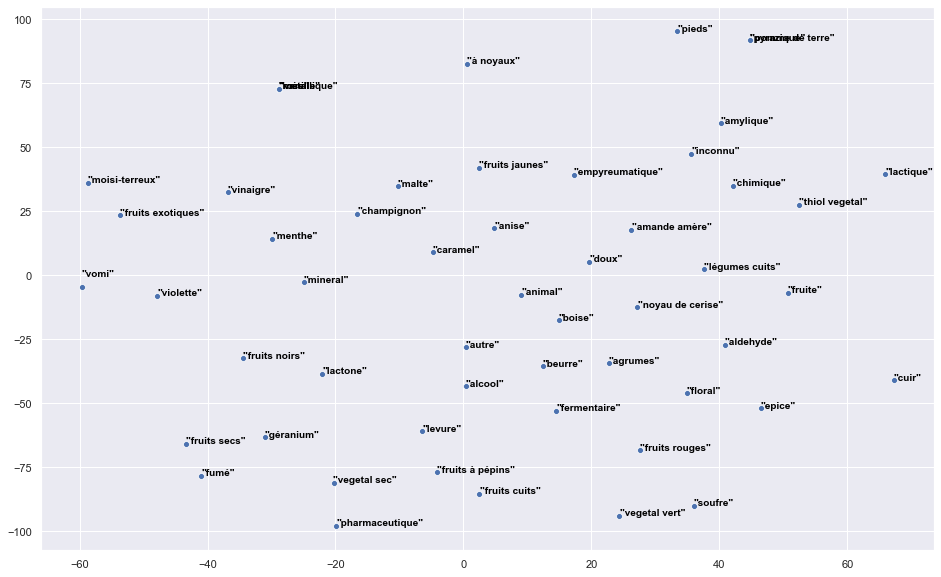

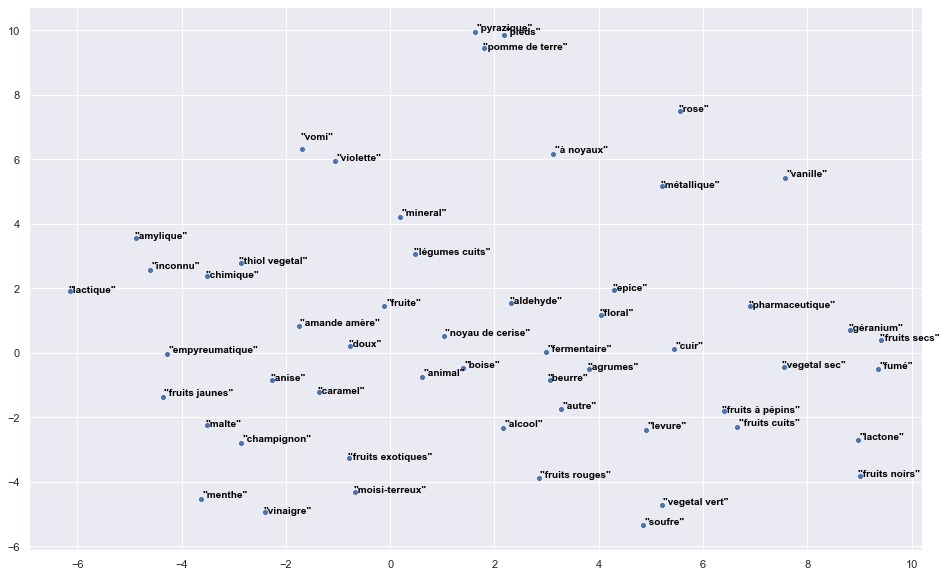

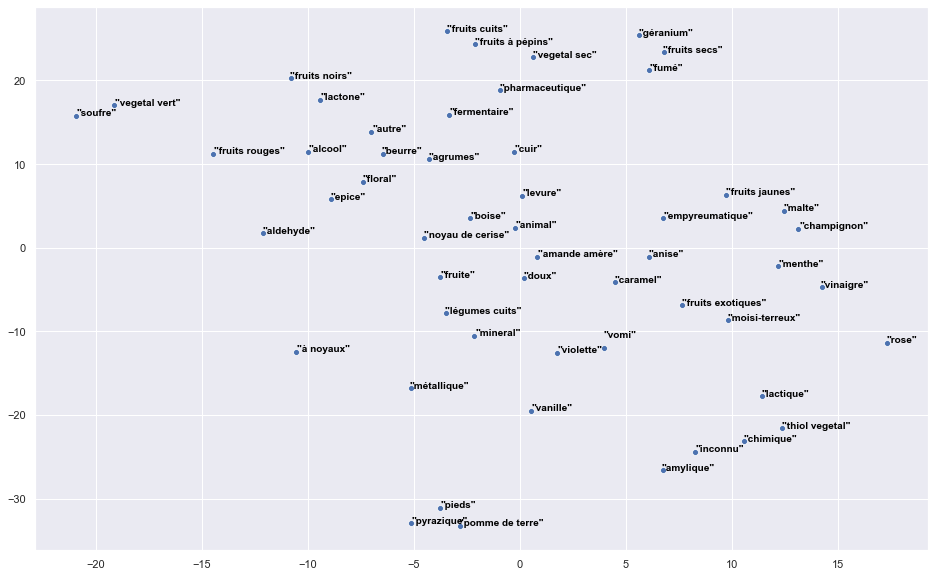

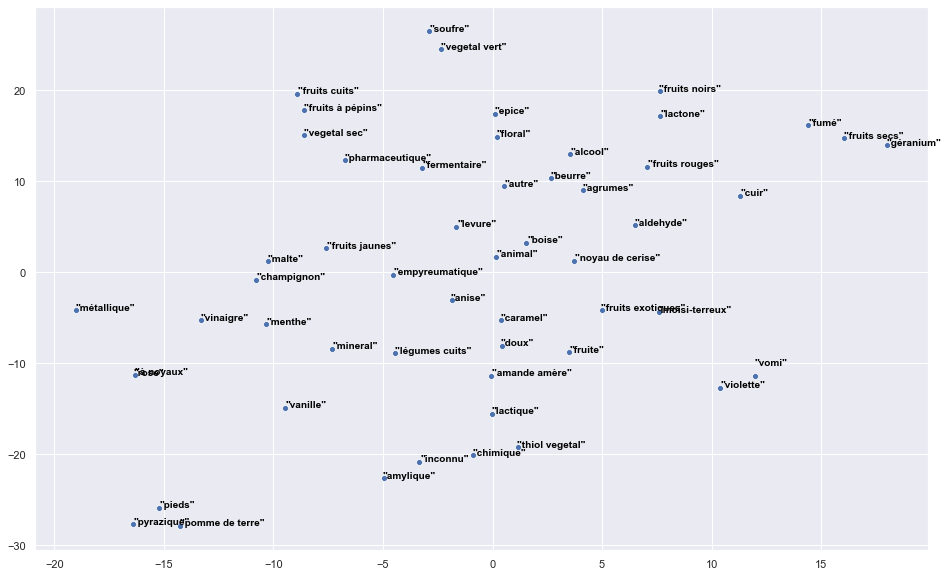

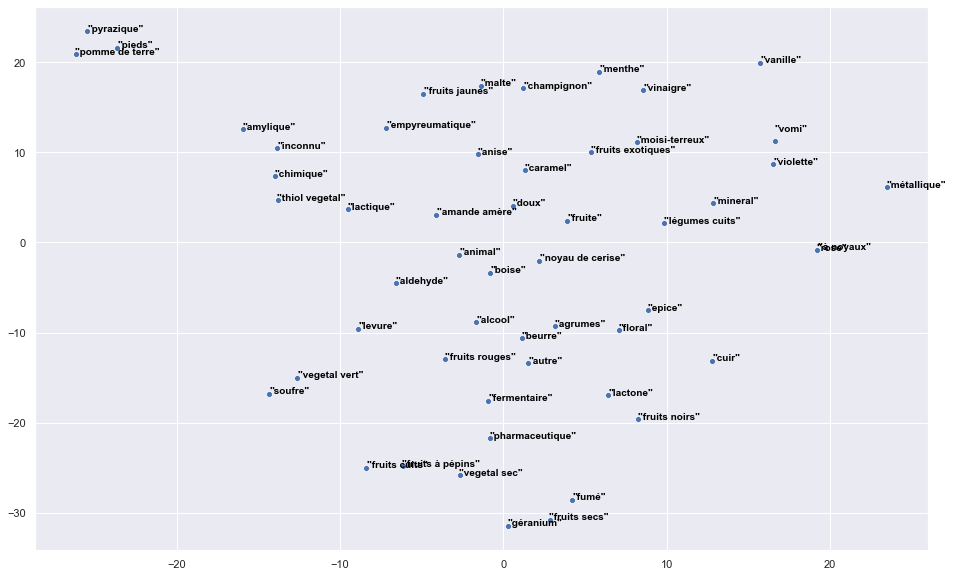

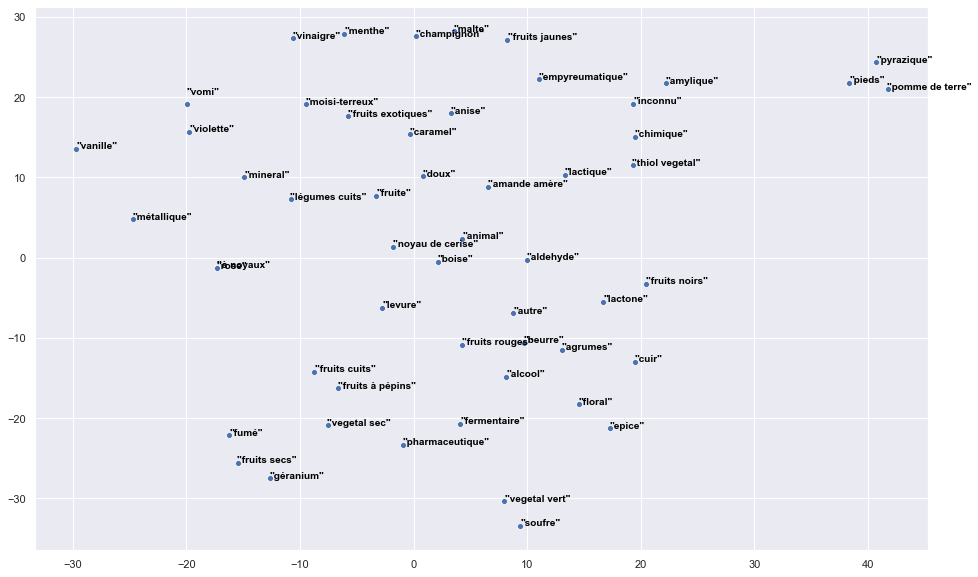

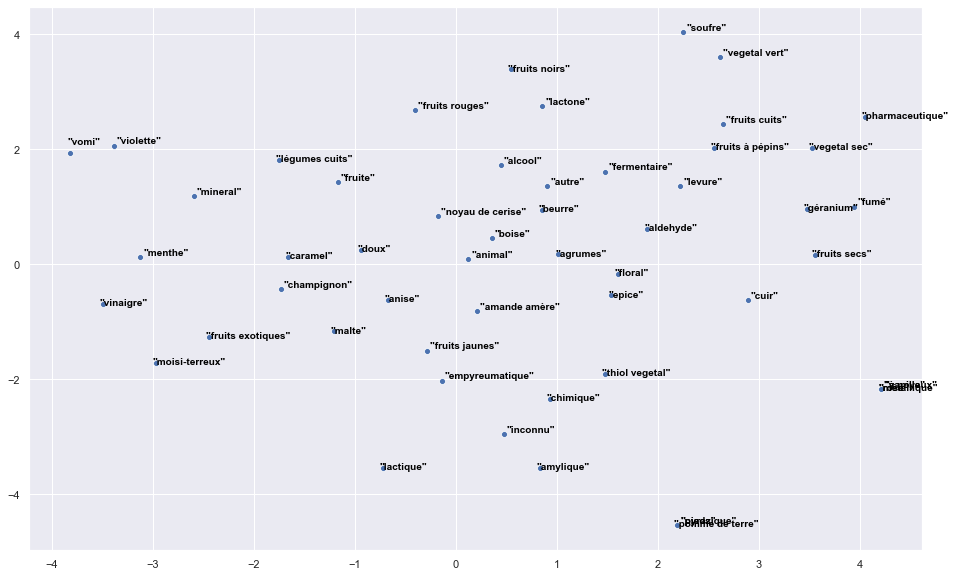

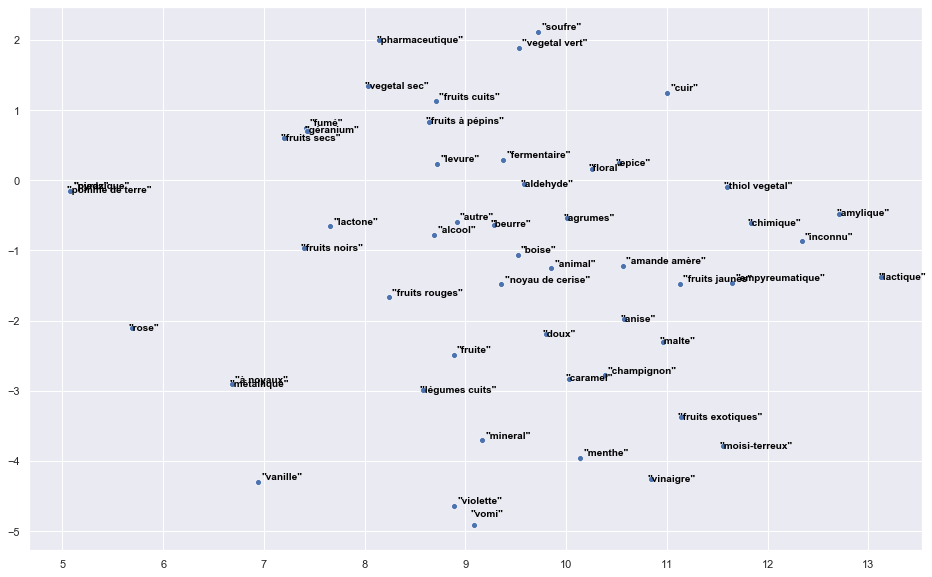

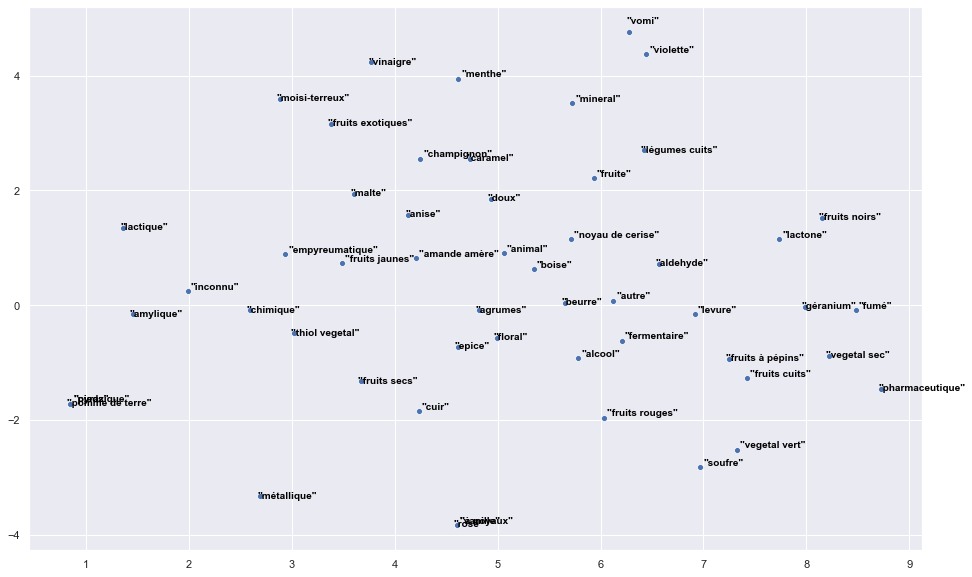

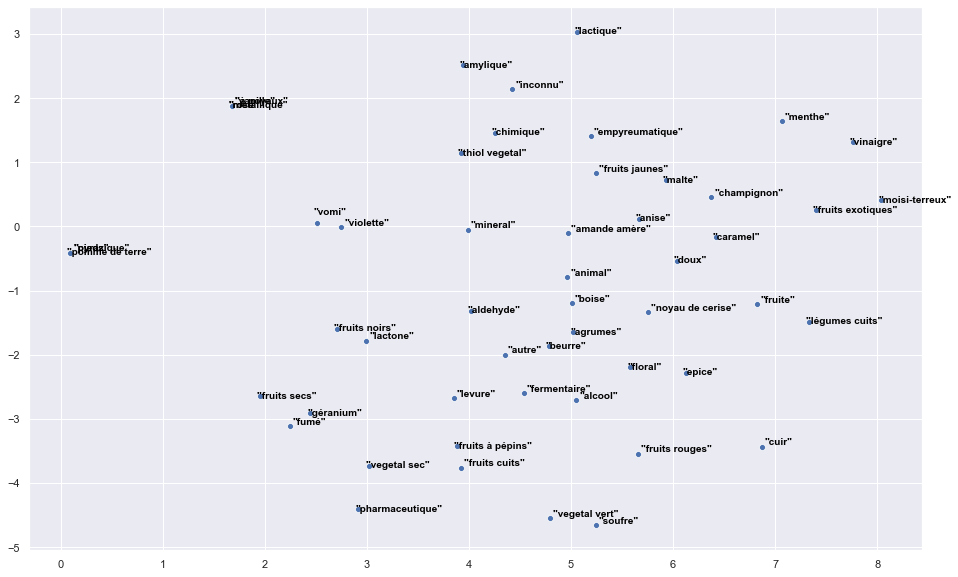

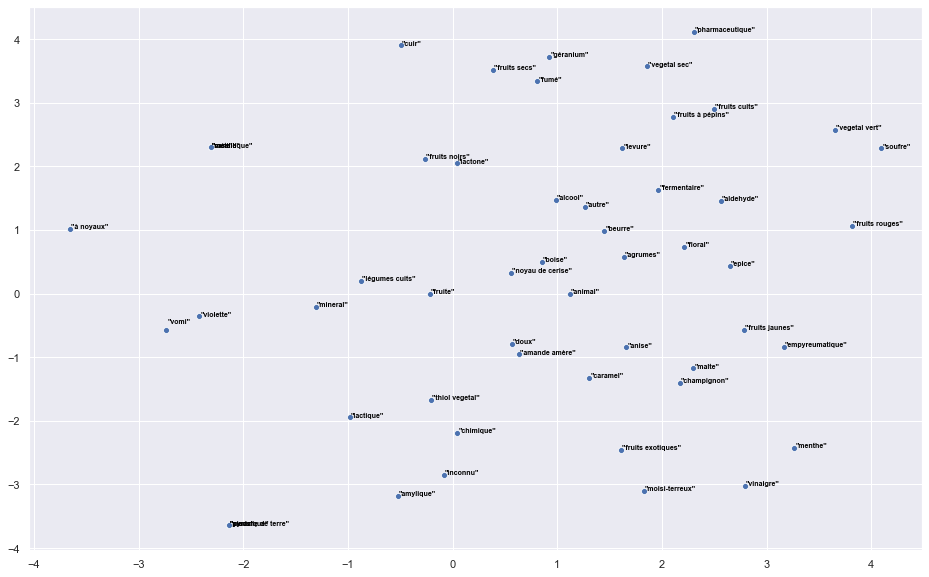

In [16]:
# calculer matrice et enlever diagonale (val à 0) trier chaque ligne en décroissant 
# et prendr les 4 premiers (vérifier si il y a des voisins lus proche > 1)
# a faire sur donnée centrée 
# -------------- DONE --------------
# regarder sur les données d'Oniris
# refaire 8-9 visu pr tsne avec données brutes (centré) en faisant varié les params 
# -------------- DONE --------------
# faire un cosinus sur les 150 premieres dimensions de l'ACP (prendre les n dimensions représentant 90% de l'info + faire tsn-e sur cette matrice)
# -------------- DONE --------------
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

cooc_mat_cosine = cosine_distances(cooc_mat)

for row in cooc_mat_cosine:
    t = np.array(row)
    indices = t.argsort()
    indices = indices[t[indices] > 0]
    print([t[indices[0]],t[indices[1]],t[indices[2]],t[indices[3]]])

listPerplexity = [10,5,20]
listLearningRate = [12,6]
listEarlyExa = [10,20]


for row in cooc_mat_cosine:
    t = np.array(row)
    indices = t.argsort()
    indices = indices[t[indices] > 0]
    print([t[indices[0]],t[indices[1]],t[indices[2]],t[indices[3]]])
for perp in listPerplexity:
    for learn in listLearningRate:
        for exa in listEarlyExa:
            tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=perp,early_exaggeration = exa,learning_rate=learn)
            X_embedded = tsne.fit_transform(cooc_mat_cosine)
            df_subset = {} 
            df_subset['tsne-2d-one'] = X_embedded[:,0]
            df_subset['tsne-2d-two'] = X_embedded[:,1]
            plt.figure(figsize=(16,10))

            p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
            index = 0
            for line in range(0,Z.shape[0]):
                if index%2 == 0:
                    decalage = 0.03
                else:
                    decalage = -0.03
                p1.text(df_subset['tsne-2d-one'][line]+decalage, df_subset['tsne-2d-two'][line]+decalage, 
                 headerText[line], horizontalalignment='left', 
                 size='small', color='black', weight='semibold')
                index+=1
            p1.figure.savefig("Visualisation/Oniris_RAW_TSNE/"+str(perp)+"_"+str(exa)+"_"+str(learn))    
    
tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=20,early_exaggeration = 12,learning_rate=10)
X_embedded = tsne.fit_transform(cooc_mat_cosine)


df_subset = {} 
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
for line in range(0,cooc_mat.shape[0]):
     p1.text(df_subset['tsne-2d-one'][line]+0.01, df_subset['tsne-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small',fontsize=7, color='black', weight='semibold')

# TSNE SUR DONNEES CENTREE REDUITE

[1.0, 1.0, 1.0, 1.0]
[0.2262975, 0.24587798, 0.25716418, 0.25895423]
[0.16559923, 0.20543122, 0.21077722, 0.2262975]
[0.17894858, 0.20543122, 0.23540759, 0.24013174]
[0.19622374, 0.22608387, 0.22947967, 0.22973084]
[0.23873013, 0.28693157, 0.3398776, 0.3556534]
[0.212538, 0.22716975, 0.23313671, 0.24052477]
[0.22608387, 0.2401784, 0.25396687, 0.26052105]
[0.18388116, 0.21077722, 0.23702335, 0.23948658]
[0.16559923, 0.17894858, 0.18388116, 0.22192156]
[0.212538, 0.22192156, 0.24048012, 0.24701005]
[0.20441419, 0.24157274, 0.25396687, 0.2775066]
[0.24157274, 0.24668998, 0.27035534, 0.27496088]
[0.22973084, 0.24838132, 0.26036674, 0.26908427]
[0.34278882, 0.3443421, 0.3473423, 0.35611874]
[0.19622374, 0.20441419, 0.24052477, 0.24668998]
[0.2632386, 0.26467144, 0.28510737, 0.30964482]
[0.25895423, 0.26921457, 0.2807715, 0.28277105]
[0.22478229, 0.23702335, 0.2443707, 0.25048047]
[0.22609466, 0.25773466, 0.26095766, 0.27660662]
[0.25764102, 0.2775066, 0.29212165, 0.33159083]
[0.21727258, 0.

[t-SNE] Iteration 900: error = 0.3355197, gradient norm = 0.0001946 (50 iterations in 0.009s)
[t-SNE] Iteration 950: error = 0.3289855, gradient norm = 0.0001761 (50 iterations in 0.011s)
[t-SNE] Iteration 1000: error = 0.3231799, gradient norm = 0.0001626 (50 iterations in 0.011s)
[t-SNE] Iteration 1050: error = 0.3177949, gradient norm = 0.0001510 (50 iterations in 0.010s)
[t-SNE] Iteration 1100: error = 0.3127661, gradient norm = 0.0001410 (50 iterations in 0.010s)
[t-SNE] Iteration 1150: error = 0.3080178, gradient norm = 0.0001322 (50 iterations in 0.012s)
[t-SNE] Iteration 1200: error = 0.3036024, gradient norm = 0.0001247 (50 iterations in 0.009s)
[t-SNE] Iteration 1250: error = 0.2991818, gradient norm = 0.0001184 (50 iterations in 0.011s)
[t-SNE] Iteration 1300: error = 0.2952008, gradient norm = 0.0001121 (50 iterations in 0.010s)
[t-SNE] Iteration 1350: error = 0.2916483, gradient norm = 0.0001060 (50 iterations in 0.010s)
[t-SNE] Iteration 1400: error = 0.2878544, gradient 

[t-SNE] Iteration 1000: error = 0.7000728, gradient norm = 0.0002298 (50 iterations in 0.009s)
[t-SNE] Iteration 1050: error = 0.6998323, gradient norm = 0.0001428 (50 iterations in 0.010s)
[t-SNE] Iteration 1100: error = 0.6995611, gradient norm = 0.0004775 (50 iterations in 0.010s)
[t-SNE] Iteration 1150: error = 0.7003642, gradient norm = 0.0001546 (50 iterations in 0.008s)
[t-SNE] Iteration 1200: error = 0.7000674, gradient norm = 0.0000719 (50 iterations in 0.008s)
[t-SNE] Iteration 1250: error = 0.6998754, gradient norm = 0.0000871 (50 iterations in 0.009s)
[t-SNE] Iteration 1300: error = 0.6996772, gradient norm = 0.0001105 (50 iterations in 0.009s)
[t-SNE] Iteration 1350: error = 0.6996244, gradient norm = 0.0000765 (50 iterations in 0.009s)
[t-SNE] Iteration 1400: error = 0.6996605, gradient norm = 0.0002974 (50 iterations in 0.008s)
[t-SNE] Iteration 1450: error = 0.6989599, gradient norm = 0.0001416 (50 iterations in 0.013s)
[t-SNE] Iteration 1500: error = 0.6986870, gradien

[t-SNE] Iteration 1150: error = 0.7140194, gradient norm = 0.0003478 (50 iterations in 0.009s)
[t-SNE] Iteration 1200: error = 0.7144448, gradient norm = 0.0001207 (50 iterations in 0.009s)
[t-SNE] Iteration 1250: error = 0.7134151, gradient norm = 0.0002624 (50 iterations in 0.010s)
[t-SNE] Iteration 1300: error = 0.7138246, gradient norm = 0.0001300 (50 iterations in 0.009s)
[t-SNE] Iteration 1350: error = 0.7134883, gradient norm = 0.0000930 (50 iterations in 0.009s)
[t-SNE] Iteration 1400: error = 0.7127744, gradient norm = 0.0000872 (50 iterations in 0.008s)
[t-SNE] Iteration 1450: error = 0.7130873, gradient norm = 0.0001201 (50 iterations in 0.009s)
[t-SNE] Iteration 1500: error = 0.7123935, gradient norm = 0.0000994 (50 iterations in 0.008s)
[t-SNE] Iteration 1550: error = 0.7122740, gradient norm = 0.0000776 (50 iterations in 0.009s)
[t-SNE] Iteration 1600: error = 0.7121275, gradient norm = 0.0000842 (50 iterations in 0.009s)
[t-SNE] Iteration 1650: error = 0.7119786, gradien

[t-SNE] Iteration 850: error = 0.2394275, gradient norm = 0.0000671 (50 iterations in 0.010s)
[t-SNE] Iteration 900: error = 0.2392764, gradient norm = 0.0001136 (50 iterations in 0.010s)
[t-SNE] Iteration 950: error = 0.2394402, gradient norm = 0.0000869 (50 iterations in 0.010s)
[t-SNE] Iteration 1000: error = 0.2394396, gradient norm = 0.0000811 (50 iterations in 0.009s)
[t-SNE] Iteration 1050: error = 0.2392789, gradient norm = 0.0001116 (50 iterations in 0.010s)
[t-SNE] Iteration 1100: error = 0.2392834, gradient norm = 0.0001227 (50 iterations in 0.010s)
[t-SNE] Iteration 1150: error = 0.2394481, gradient norm = 0.0000878 (50 iterations in 0.010s)
[t-SNE] Iteration 1200: error = 0.2394517, gradient norm = 0.0000788 (50 iterations in 0.010s)
[t-SNE] Iteration 1250: error = 0.2392920, gradient norm = 0.0001112 (50 iterations in 0.010s)
[t-SNE] Iteration 1250: did not make any progress during the last 300 episodes. Finished.
[t-SNE] KL divergence after 1250 iterations: 0.239292
[t-S

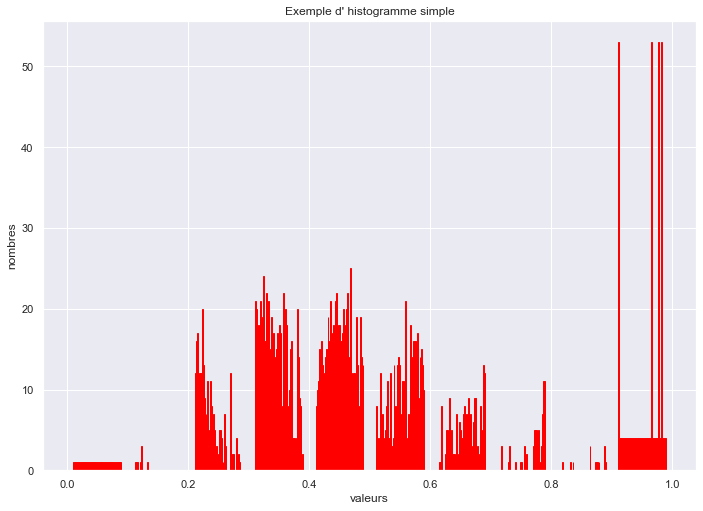

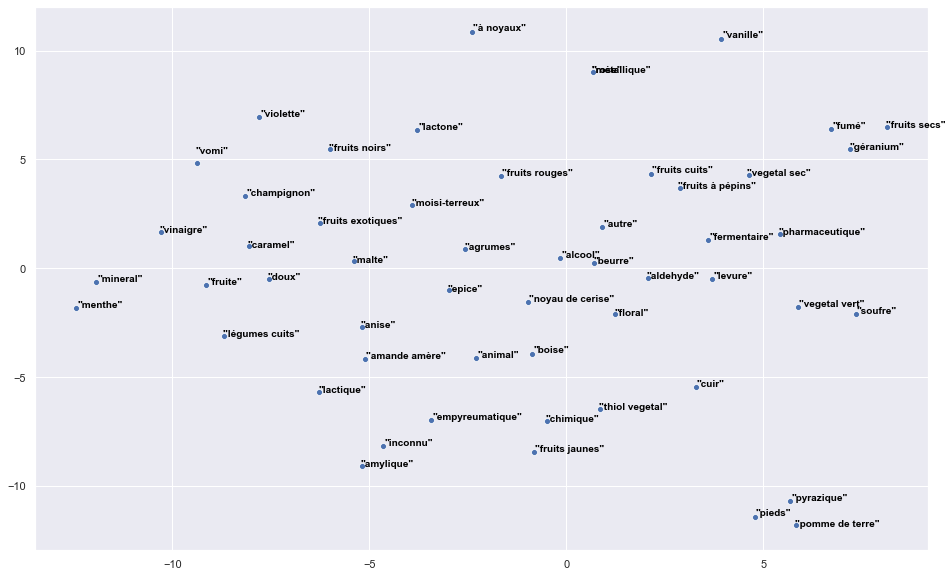

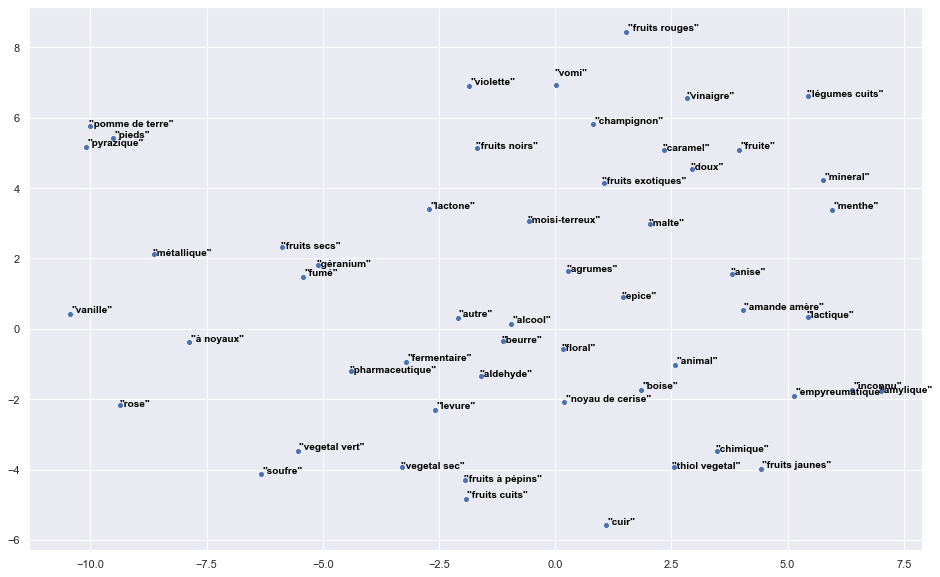

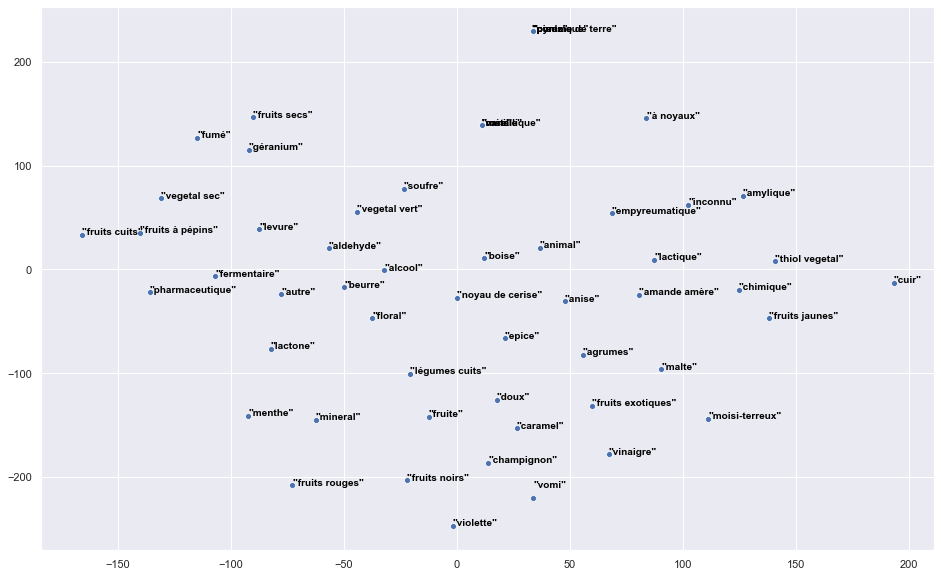

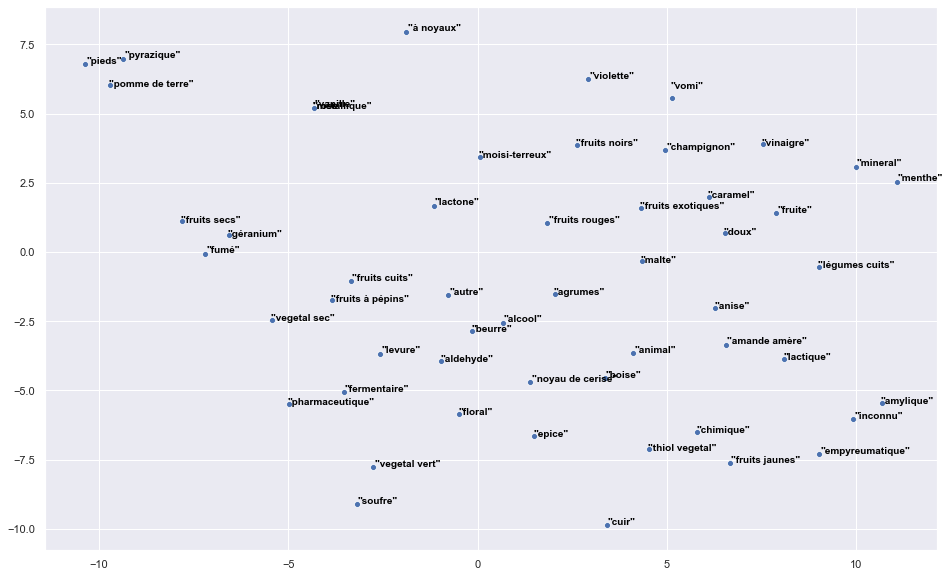

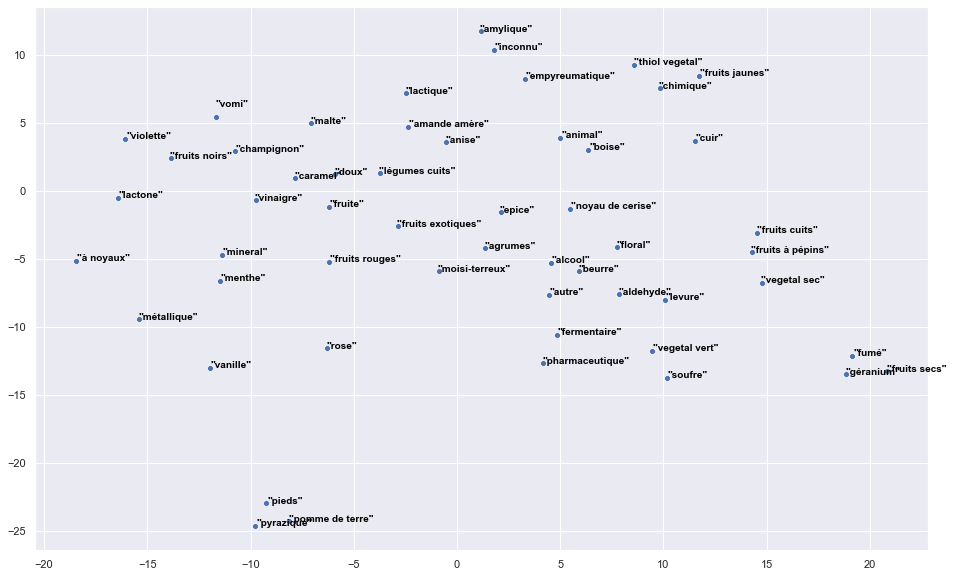

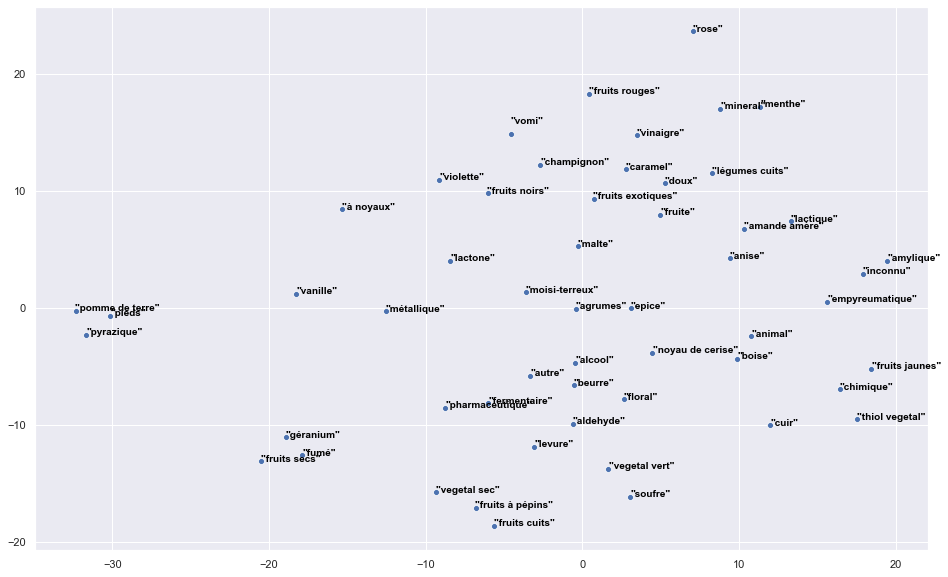

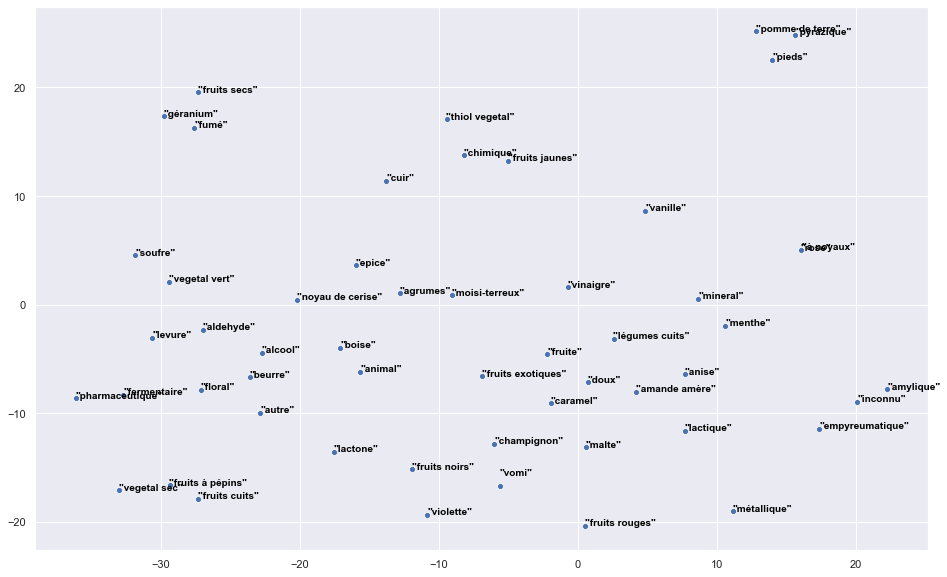

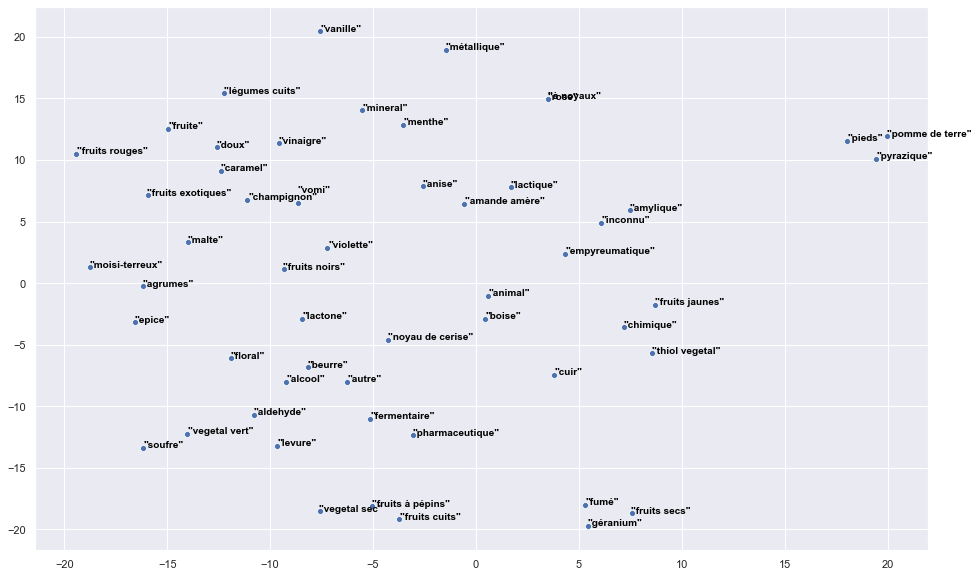

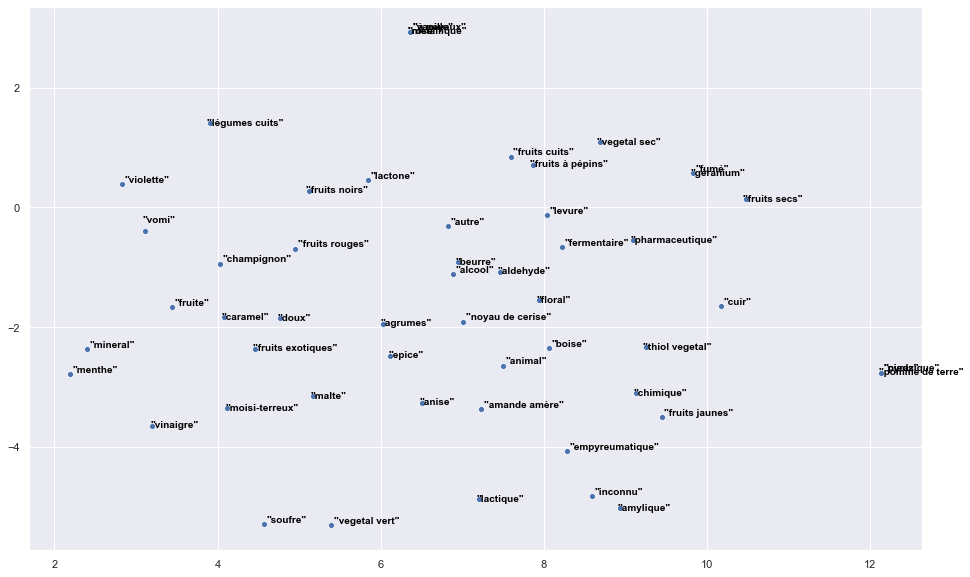

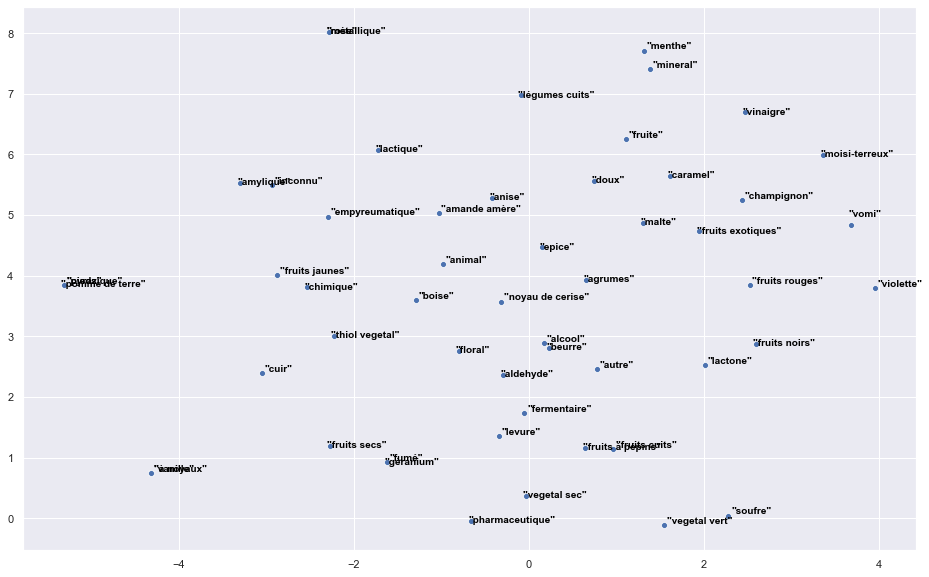

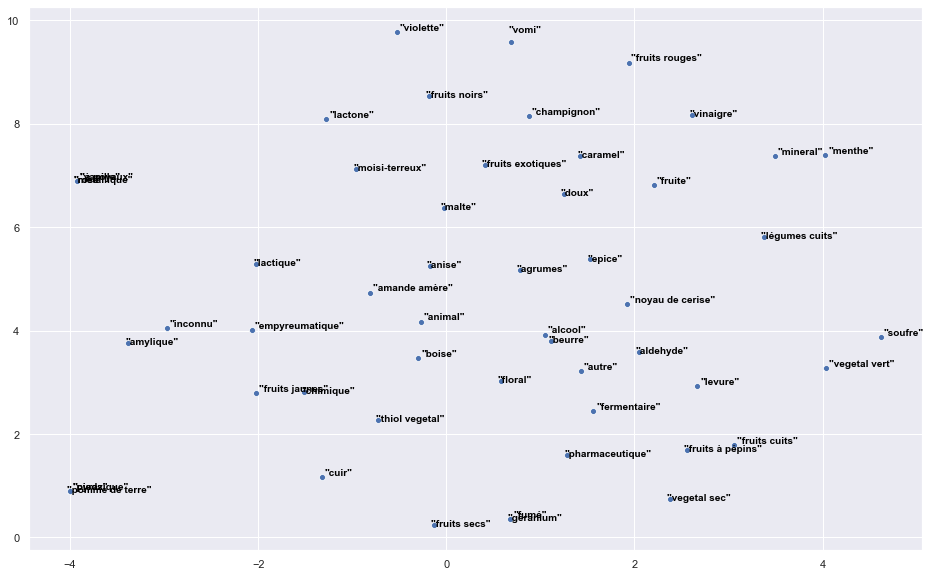

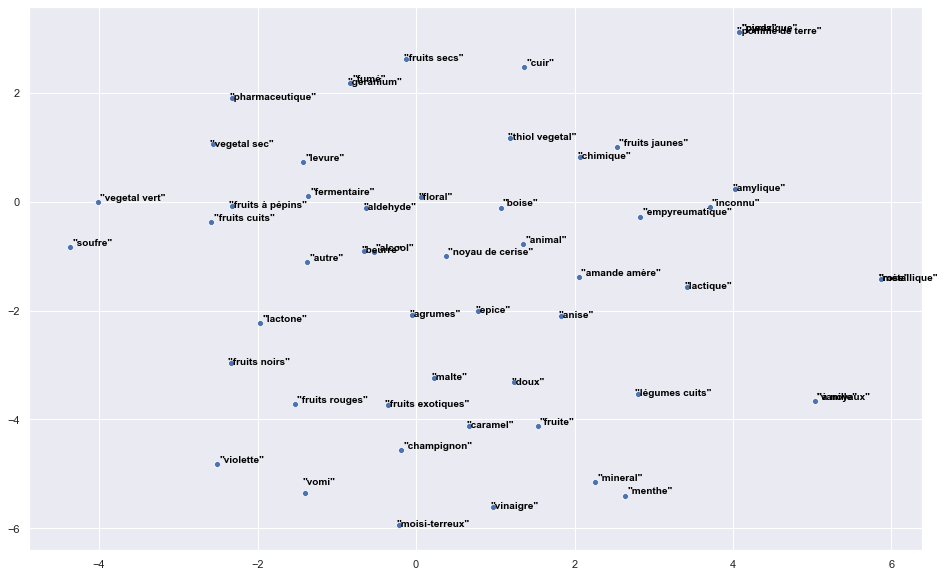

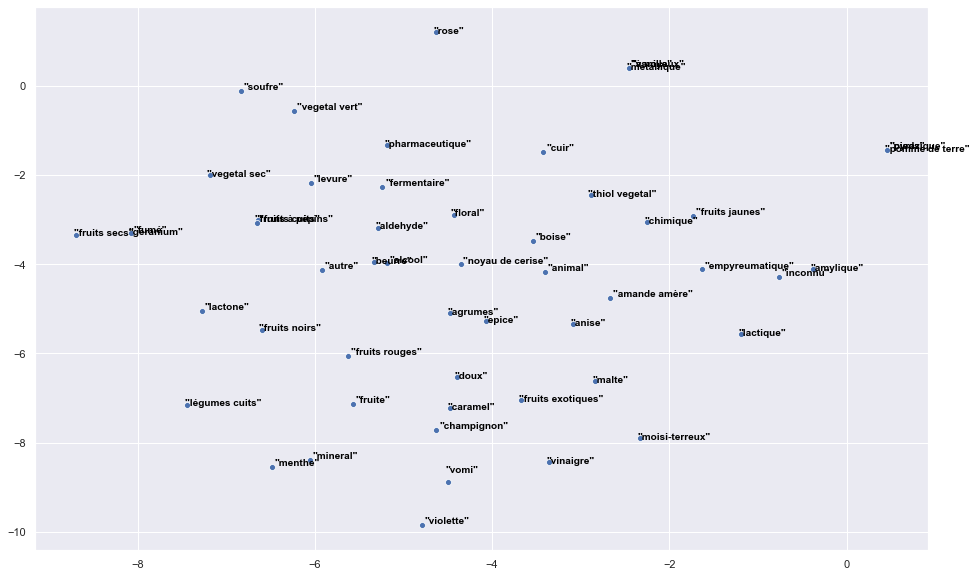

In [20]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
Z = sc.fit_transform(cooc_mat)

sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

cooc_mat_cosine = cosine_distances(Z)

plt.hist(cooc_mat_cosine, range = (0, 1),
            edgecolor = 'red')
plt.xlabel('valeurs')
plt.ylabel('nombres')
plt.title('Exemple d\' histogramme simple')


listPerplexity = [10,5,20]
listLearningRate = [12,6]
listEarlyExa = [10,20]


for row in cooc_mat_cosine:
    t = np.array(row)
    indices = t.argsort()
    indices = indices[t[indices] > 0]
    print([t[indices[0]],t[indices[1]],t[indices[2]],t[indices[3]]])
for perp in listPerplexity:
    for learn in listLearningRate:
        for exa in listEarlyExa:
            tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=perp,early_exaggeration = exa,learning_rate=learn)
            X_embedded = tsne.fit_transform(cooc_mat_cosine)
            df_subset = {} 
            df_subset['tsne-2d-one'] = X_embedded[:,0]
            df_subset['tsne-2d-two'] = X_embedded[:,1]
            plt.figure(figsize=(16,10))

            p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
            index = 0
            for line in range(0,Z.shape[0]):
                if index%2 == 0:
                    decalage = 0.03
                else:
                    decalage = -0.03
                p1.text(df_subset['tsne-2d-one'][line]+decalage, df_subset['tsne-2d-two'][line]+decalage, 
                 headerText[line], horizontalalignment='left', 
                 size='small', color='black', weight='semibold')
                index+=1
            p1.figure.savefig("Visualisation/"+str(perp)+"_"+str(exa)+"_"+str(learn))
tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=20,early_exaggeration = 12,learning_rate=10)
X_embedded = tsne.fit_transform(cooc_mat_cosine)
df_subset = {} 
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))

p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
index = 0
for line in range(0,Z.shape[0]):
    if index%2 == 0:
        decalage = 0.03
    else:
        decalage = -0.03
    p1.text(df_subset['tsne-2d-one'][line]+decalage, df_subset['tsne-2d-two'][line]+decalage, 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')
    index+=1
p1.figure.savefig("output.png")

([<matplotlib.axis.XTick at 0x2a429efc5c0>,
 <a list of 25 Text xticklabel objects>)

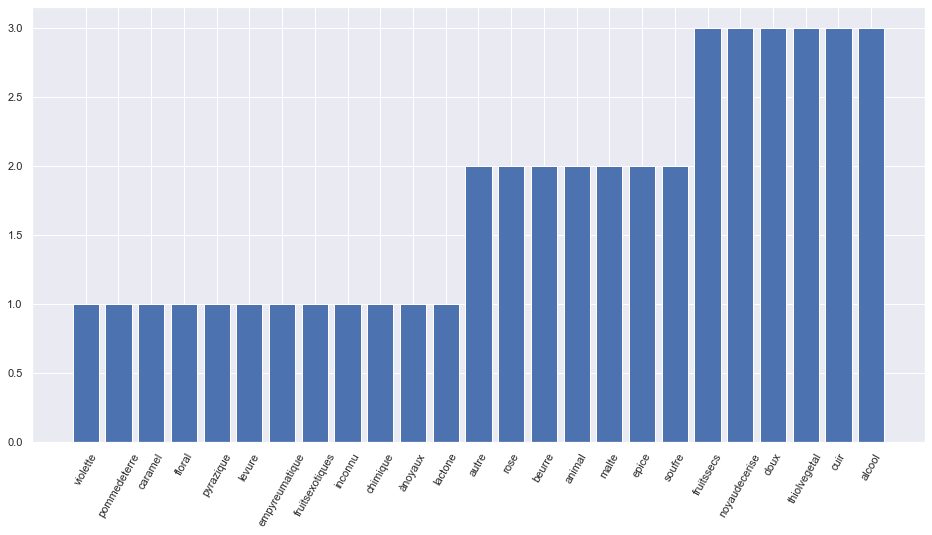

In [62]:
word = 'boise'
assert word in tokenizer.word_index, 'Word {} is not in the tokenizer'.format(word)
assert tokenizer.word_index[word] <= v_size, 'The word {} is an out of vocabuary word. Please try something else'.format(word)

rev_word_index = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))

cooc_vec = np.array(cooc_mat.getrow(tokenizer.word_index[word]).todense()).ravel()
max_ind = np.argsort(cooc_vec)[-25:]
#print(max_ind)
plt.figure(figsize=(16,8))
plt.bar(np.arange(0, 25), cooc_vec[max_ind])
plt.xticks(ticks=np.arange(0, 25), labels=[rev_word_index[i] for i in max_ind], rotation=60)

In [11]:
def create_glove_model(v_size):    
    w_i = Input(shape=(1,))
    w_j = Input(shape=(1,))

    emb_i = Flatten()(Embedding(v_size, 10, input_length=1)(w_i))
    emb_j = Flatten()(Embedding(v_size, 10, input_length=1)(w_j))

    ij_dot = Dot(axes=-1)([emb_i,emb_j])
    
    b_i = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_i)
    )
    b_j = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_j)
    )

    pred = Add()([ij_dot, b_i, b_j])

    def glove_loss(y_true, y_pred):
        return K.sum(
            K.pow((y_true-1)/100.0, 0.75)*K.square(y_pred - K.log(y_true))
        )

    model = Model(inputs=[w_i, w_j],outputs=pred)
    model.compile(loss=glove_loss, optimizer =Adam(lr=0.0001))
    return model


In [12]:
K.clear_session()
model = create_glove_model(v_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 10)        540         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        540         input_2[0][0]                    
______________________________________________________________________________________________

In [18]:
cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz'))
batch_size =35
copy_docs = list(docs)
index2word = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
""" Each epoch """
for ep in range(10):
    
    #valid_words = get_valid_words(docs, 20, tokenizer)
    
    random.shuffle(copy_docs)
    losses = []
    """ Each document (i.e. movie plot) """
    for doc in copy_docs:
        
        seq = tokenizer.texts_to_sequences([doc])[0]

        """ Getting skip-gram data """
        # Negative samples are automatically sampled by tf loss function
        wpairs, labels = skipgrams(
            sequence=seq, vocabulary_size=v_size, negative_samples=0.0, shuffle=True
        )
        
        if len(wpairs)==0:
            continue

        sg_in, sg_out = zip(*wpairs)
        sg_in, sg_out = np.array(sg_in).reshape(-1,1), np.array(sg_out).reshape(-1,1)
        x_ij = np.array(cooc_mat[sg_in[:,0], sg_out[:,0]]).reshape(-1,1) + 1
        
        assert np.all(np.array(labels)==1)
        assert x_ij.shape[0] == sg_in.shape[0], 'X_ij {} shape does not sg_in {}'.format(x_ij.shape, sg_in.shape)
        """ For each batch in the dataset """
        model.fit([sg_in, sg_out], x_ij, batch_size = batch_size, epochs=1, verbose=0)
        l = model.evaluate([sg_in, sg_out], x_ij, batch_size=batch_size, verbose=0)
        losses.append(l)
    print('Loss in epoch {}: {}'.format(ep, np.mean(losses)))

Loss in epoch 0: 3.0189515554881203
Loss in epoch 1: 2.928335235918519
Loss in epoch 2: 2.8512903761557182
Loss in epoch 3: 2.8158311853945923
Loss in epoch 4: 2.7257918654628837
Loss in epoch 5: 2.6080699933619753
Loss in epoch 6: 2.5882413431445923
Loss in epoch 7: 2.521320236025027
Loss in epoch 8: 2.4285880056688023
Loss in epoch 9: 2.392150382701888


In [14]:
def save_embeddings(model,save_dir, tok, v_size):
    """ Saving data to disk """
    
    # We need to add the 0th index to word list manually
    word_list = ["RESERVED"]+[tok.index_word[w_i] for w_i in range(1,v_size)]
    emb_w_df = None
    for layer in model.layers:
        if 'embedding' == layer.name or 'embedding_1' == layer.name:
            if emb_w_df is None:
                emb_w_df = pd.DataFrame(layer.get_weights()[0])
            else:
                emb_w_df += layer.get_weights()[0]
    
    emb_w_df.insert(0, "word", word_list)
            
    emb_w_df.to_csv(
        os.path.join(save_dir, 'embeddings_w_Oniris.csv'), index=False, header=None
    )
    
save_embeddings(model, 'datasets', tokenizer, v_size)
model.save('glove_model_Oniris.h5')

RuntimeError: Unable to create link (name already exists)

In [19]:

def get_valid_words(docs, size, tok):
    """ Get a random set of words to check the embeddings """
    np.random.seed(120)
    valid_docs = np.random.choice(docs, size=size//2)
    valid_words = []
    for doc in valid_docs:
        np.random.seed(100)
        words = np.random.choice(tok.texts_to_sequences([doc])[0],size=2)
        valid_words.extend(words)
        
    return valid_words
        
valid_words = get_valid_words(docs, 10, tokenizer)
def load_embeddings(filename):
    print('Loading the word embeddings from the disk')
    embed_df = pd.read_csv(filename, index_col=False, header=None)
    embed_df = embed_df.set_index(0)
    print('Embedding shape: {}'.format(embed_df.shape))
    embed_mat = embed_df.values
    words = embed_df.index.values
    return embed_mat, words

def get_cosine_sim(emb, valid_words, top_k):
    norm = np.sqrt(np.sum(emb**2,axis=1,keepdims=True))
    norm_emb = emb/norm
    in_emb = norm_emb[valid_words,:]
    similarity = np.dot(in_emb, np.transpose(norm_emb))
    sorted_ind = np.argsort(-similarity, axis=1)[:,1:top_k+1]
    return sorted_ind, valid_words

embed_mat, words = load_embeddings(os.path.join('datasets','embeddings_w_Oniris.csv'))
print(embed_mat)
print(words)
best_ids, wids = get_cosine_sim(embed_mat, valid_words, 5)
pd.Series(words).to_csv(os.path.join('datasets','index2word_Oniris.csv'))
for w, bi in zip(wids, best_ids):
    print("{}: {}".format(words[w], ', '.join(words[bii] for bii in bi)))
    

Loading the word embeddings from the disk
Embedding shape: (54, 10)
[[-0.05306488 -0.06244825 -0.00332136 -0.03877643 -0.01143817  0.02263204
  -0.00711167 -0.00536141  0.00877305 -0.08596028]
 [ 0.10342321  0.00332558 -0.1622589  -0.0121057   0.22686884  0.09112772
   0.12224149  0.1065571  -0.07594161 -0.1772521 ]
 [ 0.08329548  0.01693692 -0.11921112 -0.00059243  0.21950933  0.11424616
   0.1642852  -0.03557332 -0.16783257 -0.15765738]
 [ 0.03289321 -0.02845761 -0.05190312 -0.00850722  0.13244818  0.12628548
   0.18839079  0.01702074 -0.11142903 -0.10707095]
 [ 0.14819911 -0.01619681 -0.17701563  0.06587857  0.21845669  0.08857603
   0.00853314  0.01557185 -0.05123449 -0.13433385]
 [ 0.02371294  0.03755518 -0.07953893 -0.03195023  0.08503316  0.0492482
   0.0205307   0.09747813 -0.03911173 -0.07963524]
 [ 0.12564608 -0.04230201 -0.08456361  0.00065049  0.15032592  0.12778029
   0.12315078  0.06791924 -0.12674789 -0.09025136]
 [ 0.05103781 -0.02912015 -0.04987603 -0.08618194  0.17653

C:\Users\Sebastien\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


0.45868355056200283
0.5859616903834806
0.6269152775735622
0.6473853484480583
0.06996605742719664
0.07387566006128132
0.0765481142807769
0.08511627132793642
0.03419211934296007
0.03632799063321035
0.06914444890457871
0.083747073658347
0.06914444890457871
0.08476966343375758
0.09032720927978344
0.10427854004828385
0.06655077098959816
0.0829821482370593
0.09321816907799296
0.10012896804128935
0.09343241271340308
0.0953613966911786
0.09611539495973631
0.1590129014010142
0.08476966343375758
0.08511627132793642
0.08660532688968137
0.09110993162608827
0.09086645166451734
0.10609304674737874
0.11069193122918097
0.11330488242886638
0.03632799063321035
0.06504780854686742
0.09032720927978344
0.10694954195060136
0.03419211934296007
0.06504780854686742
0.08660532688968137
0.0895607336803732
0.07146376370097396
0.08083011934546525
0.083747073658347
0.0895607336803732
0.08629162588792416
0.0944221956183855
0.09697958185748512
0.1002652466924352
0.06996605742719664
0.0953613966911786
0.13270832737204

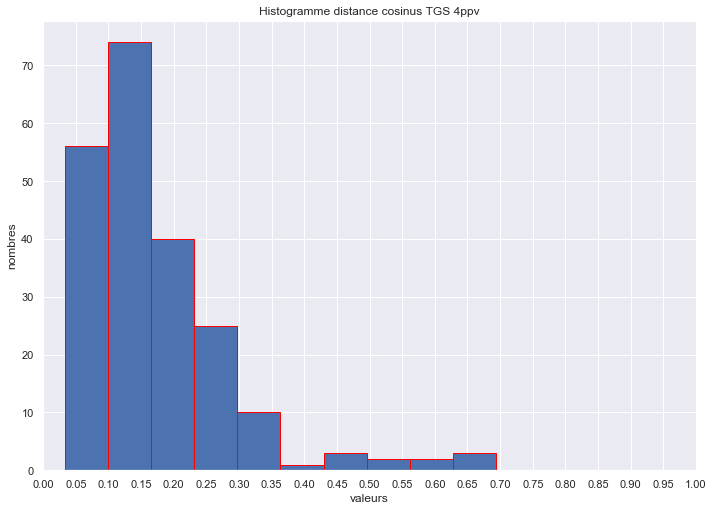

In [20]:
from sklearn.metrics.pairwise import cosine_distances
from scipy import stats

#print(stats.describe(embed_mat))
cosine_matrix = cosine_distances(embed_mat)
mb1 = [0,0.05,0.1,0.15,0.20,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
kppv_distance = np.empty([216],dtype=float)
index=0
for row in cosine_matrix:
    t = np.array(row)
    indices = t.argsort()
    indices = indices[t[indices] > 0]
    kppv_distance[index] = t[indices[0]]
    index+=1
    kppv_distance[index] = t[indices[1]]
    index+=1
    kppv_distance[index] = t[indices[2]]
    index+=1
    kppv_distance[index] = t[indices[3]]
    index+=1

for val in kppv_distance:
    print(val)
plt.hist(kppv_distance,edgecolor = 'red')
plt.xlabel('valeurs')
plt.ylabel('nombres')
plt.xticks(mb1)
plt.title('Histogramme distance cosinus TGS 4ppv')
plt.show()

Loading the word embeddings from the disk
Embedding shape: (54, 10)
[[0.         0.84588804 0.88207688 ... 1.04048868 1.00541313 0.71360019]
 [0.84588804 0.         0.10464022 ... 0.32995556 0.49808296 0.62510831]
 [0.88207688 0.10464022 0.         ... 0.57062514 0.4251667  0.67257834]
 ...
 [1.04048868 0.32995556 0.57062514 ... 0.         0.44401275 0.86508808]
 [1.00541313 0.49808296 0.4251667  ... 0.44401275 0.         1.18957247]
 [0.71360019 0.62510831 0.67257834 ... 0.86508808 1.18957247 0.        ]]
(54, 54)
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.001s...
[t-SNE] Computed neighbors for 54 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.154011
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 24.1731110, gradient norm = 0.7653499 (50 iterations in 0.015s)
[t-SNE] Iteration 100: error = 24.2443142, gradient norm = 0.8094746 (50 iterations in 0.019s)
[t-SNE] I

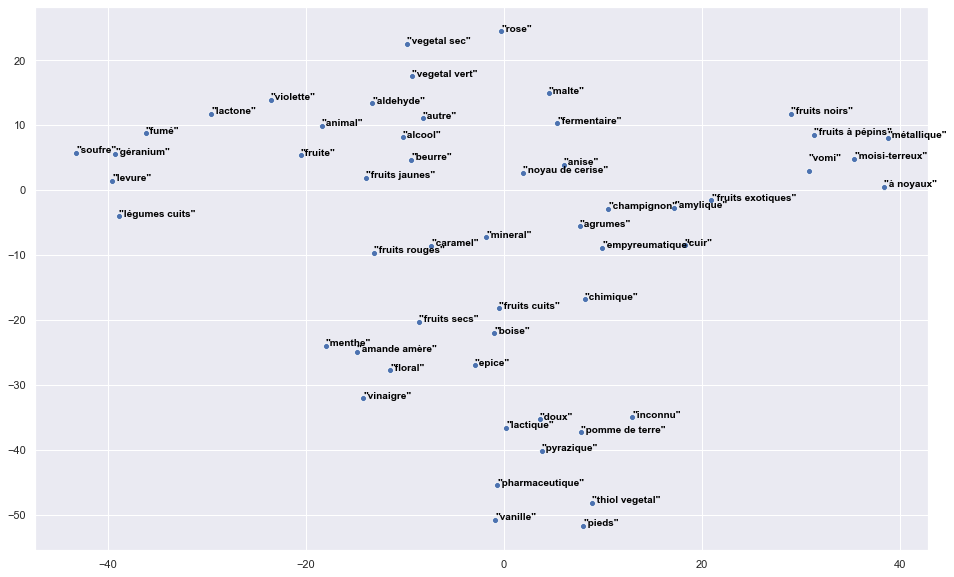

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
def getCosineMatrix(emb):
    matrix = pairwise_distances(emb, metric='cosine', n_jobs=-1)
    return np.abs(matrix)
embed_mat, words = load_embeddings(os.path.join('datasets','embeddings_w_Oniris.csv'))
cosine_matrix = getCosineMatrix(embed_mat)

cosine_matrix2 = cosine_distances(embed_mat)
print(cosine_matrix2)
#print(cosine_matrix)
print(cosine_matrix.shape)

#tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=15,early_exaggeration = 6)

listBatch = [20,30,40]
listPerplexity = [10,5,20]
listLearningRate = [12,6]
listEarlyExa = [10,20]

tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter=2000,perplexity=5,early_exaggeration = 6,learning_rate=20)
X_embedded = tsne.fit_transform(cosine_distances(embed_mat))
df_subset = {} 
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
for line in range(0,embed_mat.shape[0]):
     p1.text(df_subset['tsne-2d-one'][line]+0.01, df_subset['tsne-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')


breaking at iteration 163 with stress 57.61733866594239
breaking at iteration 113 with stress 59.95958125747535
breaking at iteration 99 with stress 60.31134492835632
breaking at iteration 178 with stress 61.22792027187104
breaking at iteration 123 with stress 61.64724477490467
breaking at iteration 211 with stress 60.1991942248481
breaking at iteration 170 with stress 56.296306691516826
breaking at iteration 90 with stress 58.584820523243195
breaking at iteration 178 with stress 62.03555890947118
breaking at iteration 112 with stress 55.82946237346201
(54, 2)


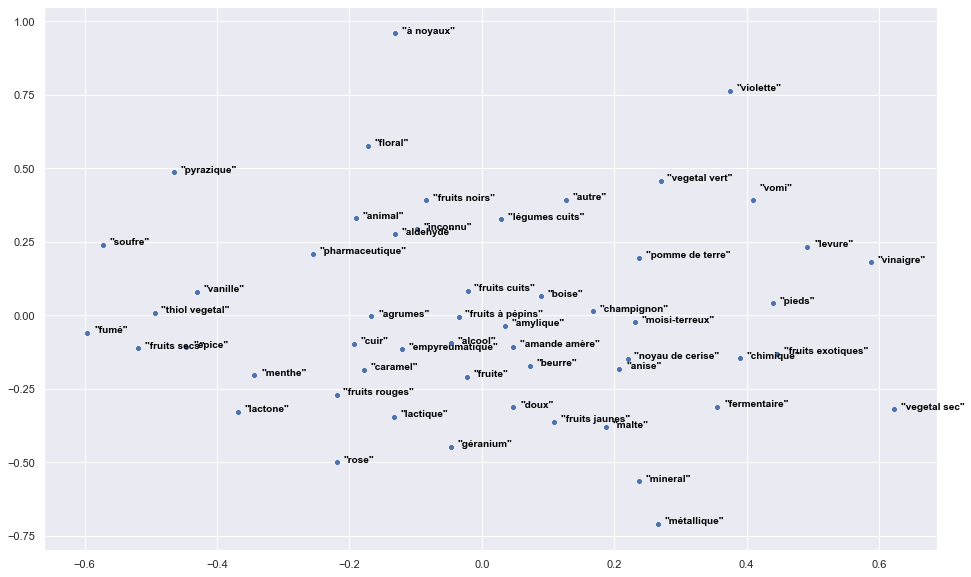

In [69]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2,verbose=1,dissimilarity='precomputed',n_init=10)
X_transformed = embedding.fit_transform(cosine_matrix)
print(X_transformed.shape)


df_subset2 = {} 
df_subset2['mds-2d-one'] = X_transformed[:,0]
df_subset2['mds-2d-two'] = X_transformed[:,1]
plt.figure(figsize=(16,10))
p2 = sns.scatterplot(X_transformed[:,0], X_transformed[:,1], legend='full', palette=palette)
for line in range(0,embed_mat.shape[0]):
     p2.text(df_subset2['mds-2d-one'][line]+0.01, df_subset2['mds-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')